In [1]:
import os
import pandas as pd
from ast import literal_eval 


In [15]:
pwd = ''

metric_list = ['accuracy', 'precision', 'recall', 'prc']


In [5]:
def read_log_dict(log_path):
    result_dict_list = []
    
    reg = '**********START:'#(\d{2}\/){2}\d{4} \d{2}(:\d{2}){2}**********'
    with open(log_path,'r') as f:
        logg = f.readlines()

    for lnum, l in reversed(list(enumerate(logg))):
        if reg in l and lnum < len(logg):

            for i in range(lnum+1, len(logg)):
                if logg[i].strip():
                    result_dict = literal_eval(logg[i].strip().strip(','))
                    result_dict_list.append(result_dict)

            break
            
    return result_dict_list
    
def get_pred(result_dict_list, metric_name='prc'):
    ratio = []
    seed = []
    metric = []
    for r in result_dict_list:
        ratio.append(r['ratio'])
        seed.append(r['seed'])
        metric.append(r[metric_name])
    return ratio, seed, metric

def get_seed_result(seed_dir, log_filename, metric_name='prc'):
    
    ratio = []
    seed = []
    metric = []
    
    result_dict_list = read_log_dict(os.path.join(seed_dir, log_filename))
    r, s, m = get_pred(result_dict_list, metric_name)
    ratio += r; seed += s; metric += m

    df_dict = pd.DataFrame({'ratio':ratio, 'seed':seed, metric_name:metric})
    metric_df = group_seed(df_dict, metric_name)
    
    return metric_df

def group_seed(metric_df, metric_name):
    metric_df_ = metric_df.loc[metric_df['seed']==0, ['ratio', metric_name]]
    metric_df_ = metric_df_.rename(columns={metric_name:metric_name+'0'})

    for i in range(1, 6):
        metric_df_[f'{metric_name}{i}'] = metric_df.loc[metric_df['seed']==i, [metric_name]].reset_index(drop=True)
    
    return metric_df_



In [ ]:
import matplotlib.pyplot as plt

def get_results(csv, model, desired_cols):
    
    target_ = csv.loc[csv['model']==model, desired_cols]
    return target_

def plot_csv_(result_file, metric, xlabel, ylabel='PR-AUC'):
    
    model = ['dense', 'single', 'tree']

    desired_cols = ['model','ratio']
    
    PRC = [c for c in result_file.columns if metric in c]
    desired_cols.extend(PRC)

    for m in model:

        r = get_results(result_file, m, desired_cols)
        rratio = r['ratio'].sort_values()
        
        plt.plot(rratio, r[PRC].mean(axis=1), '-o', label=m.replace('single','transformer'))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.ylim([0, 1])
        plt.legend()
        
    plt.show()
    
    return r[PRC].mean(axis=1)


# experiments 1 2

In [10]:
def get_exp_2(metric_name, file_dir, true_cnt):
    dfs = []
    for model in ['single','dense','tree']:
        prc_df = get_seed_result(file_dir, model+'.log', metric_name)
        prc_df['model'] = pd.Series([model]*prc_df.shape[0])
        prc_df['ratio'] = (prc_df['ratio']*true_cnt).astype(int)
        dfs.append(prc_df)
    df = pd.concat(dfs)
    # df.to_csv(pwd+'log/experiment2/logs.csv',index=False)
    return df

def get_true_cnt(path):
    
    y = pd.read_csv(path)['binding']
    cls_cnt = y.value_counts()
    
    return cls_cnt.loc[cls_cnt.index==True].iloc[0]



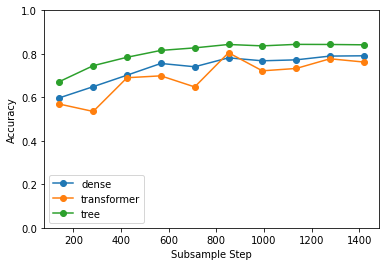

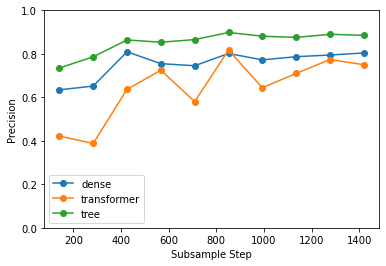

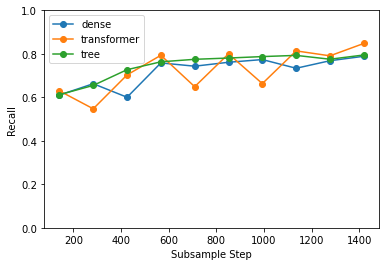

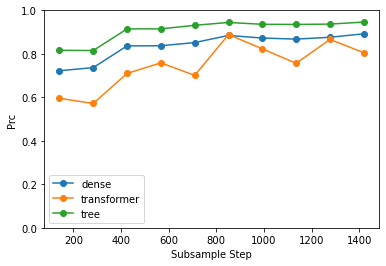

,model,ratio,accuracy,precision,recall,prc
0,single,141,0.672414,0.735091,0.612228,0.816314
1,single,283,0.745614,0.786397,0.654753,0.815252
2,single,425,0.784314,0.863927,0.727163,0.914845
3,single,567,0.815789,0.853507,0.763340,0.914927
4,single,709,0.827465,0.865492,0.774884,0.931335
5,single,851,0.843080,0.898422,0.780724,0.944413
6,single,993,0.836683,0.881083,0.787426,0.935881
7,single,1135,0.843612,0.875727,0.792881,0.935300
8,single,1277,0.843099,0.889707,0.775290,0.936835
9,single,1419,0.841549,0.885394,0.794753,0.946259


In [14]:

true_cnt = get_true_cnt(pwd+'data/experiment2/HA_y.csv')
dfs = []

for m in metric_list:
    df = get_exp_2(m, pwd+'log/experiment1/', true_cnt)
    df_avg = plot_csv_(df, metric=m,xlabel='Subsample Step',ylabel=m.capitalize())    
    dfs.append(df_avg)

df_ = df.loc[:, ['model','ratio']]

for i in range(len(dfs)):
    df_[metric_list[i]] = dfs[i]

display(df_)
    

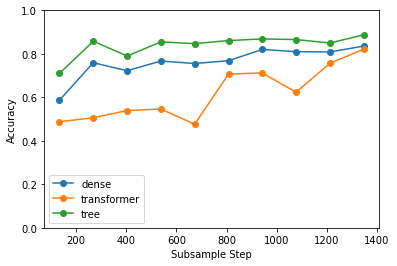

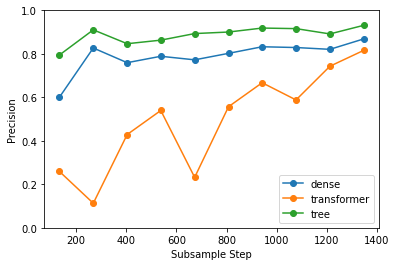

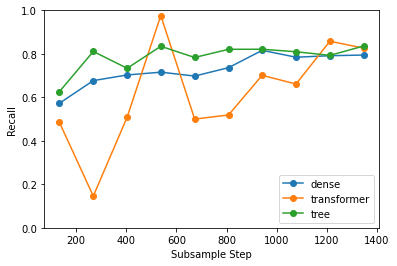

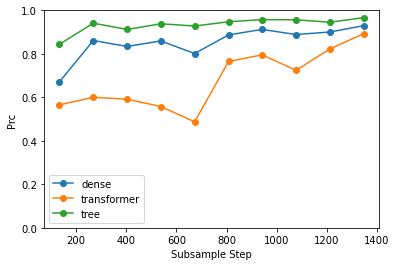

,model,ratio,accuracy,precision,recall,prc
0,single,134,0.709877,0.794625,0.626209,0.843842
1,single,269,0.858025,0.910434,0.810972,0.941175
2,single,404,0.790123,0.846577,0.733647,0.912009
3,single,538,0.854938,0.862996,0.834811,0.938376
4,single,673,0.846914,0.893254,0.783266,0.927904
5,single,808,0.861111,0.900338,0.820904,0.947608
6,single,942,0.868607,0.918605,0.821184,0.957367
7,single,1077,0.865741,0.915988,0.809652,0.956648
8,single,1212,0.849794,0.891609,0.792968,0.945398
9,single,1347,0.887654,0.931267,0.836190,0.966563


In [16]:
true_cnt = get_true_cnt(pwd+'data/experiment2/HA-ANARCI_y.csv')
dfs = []

for m in metric_list:
    df = get_exp_2(m, pwd+'log/experiment2/', true_cnt)
    df_avg = plot_csv_(df, metric=m,xlabel='Subsample Step',ylabel=m.capitalize())    
    dfs.append(df_avg)

df_ = df.loc[:, ['model','ratio']]

for i in range(len(dfs)):
    df_[metric_list[i]] = dfs[i]

display(df_)
    

# experiment 3 4

In [4]:
def get_exp_4(metric_name, file_dir):
    dfs = []
    for model in ['single','dense','tree']:
        prc_df = get_seed_result(file_dir, model+'.log', metric_name)
        prc_df['model'] = pd.Series([model]*prc_df.shape[0])
        dfs.append(prc_df)
    df = pd.concat(dfs)
    # df.to_csv(pwd+'log/experiment2/logs.csv',index=False)
    return df


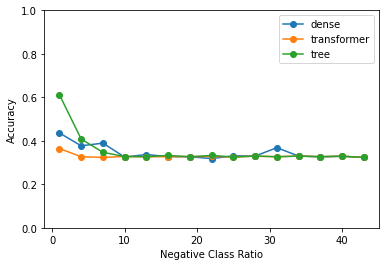

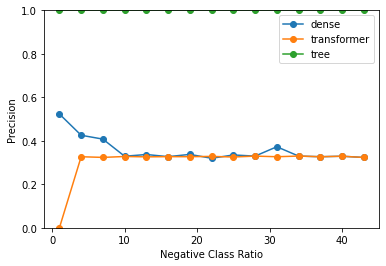

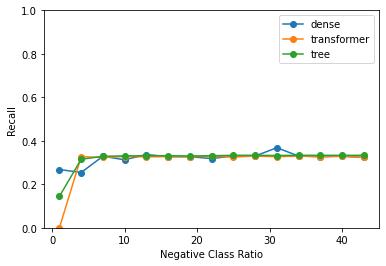

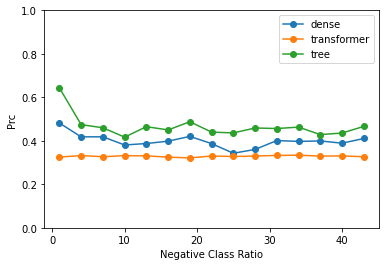

,model,ratio,accuracy,precision,recall,prc
0,single,1.0,0.612258,1.0,0.144665,0.643407
1,single,4.0,0.408275,1.0,0.315104,0.474456
2,single,7.0,0.347028,1.0,0.328881,0.460052
3,single,10.0,0.327864,1.0,0.330688,0.416983
4,single,13.0,0.327086,1.0,0.331349,0.465096
5,single,16.0,0.332600,1.0,0.331541,0.450029
6,single,19.0,0.326952,1.0,0.330243,0.487786
7,single,22.0,0.332679,1.0,0.331541,0.440038
8,single,25.0,0.325543,1.0,0.333333,0.436332
9,single,28.0,0.329715,1.0,0.333333,0.459008


In [9]:
dfs = []
metric_list = ['accuracy', 'precision', 'recall', 'prc']

for m in metric_list:
    df = get_exp_4(m, pwd+'log/experiment3/')
    df_avg = plot_csv_(df, metric=m,xlabel='Negative Class Ratio',ylabel=m.capitalize())
    dfs.append(df_avg)

df_ = df.loc[:, ['model','ratio']]

for i in range(len(dfs)):
    df_[metric_list[i]] = dfs[i]

display(df_)

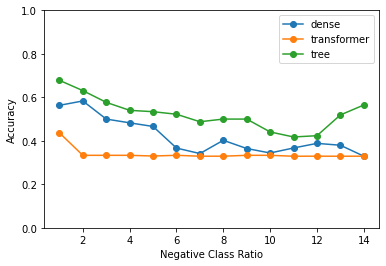

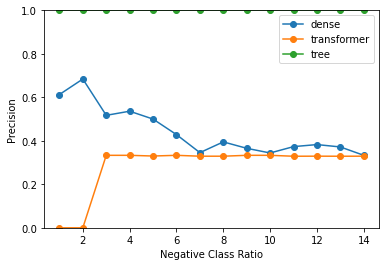

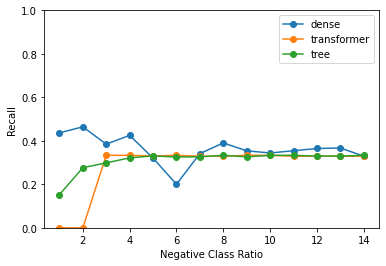

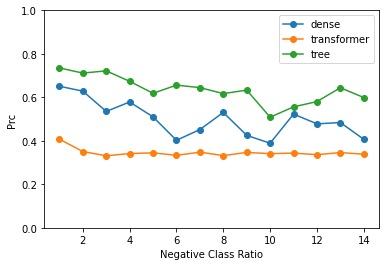

,model,ratio,accuracy,precision,recall,prc
0,single,1.0,0.678161,1.0,0.152476,0.735401
1,single,2.0,0.630952,1.0,0.276389,0.711482
2,single,3.0,0.576923,1.0,0.298611,0.721819
3,single,4.0,0.540230,1.0,0.321558,0.673675
4,single,5.0,0.533981,1.0,0.330729,0.618500
5,single,6.0,0.522222,1.0,0.325588,0.656224
6,single,7.0,0.487805,1.0,0.326389,0.644673
7,single,8.0,0.500000,1.0,0.333333,0.617201
8,single,9.0,0.500000,1.0,0.326389,0.633195
9,single,10.0,0.440860,1.0,0.333333,0.508630


In [10]:
dfs = []
metric_list = ['accuracy', 'precision', 'recall', 'prc']

for m in metric_list:
    df = get_exp_4(m, pwd+'log/experiment4/')
    df_avg = plot_csv_(df, metric=m,xlabel='Negative Class Ratio',ylabel=m.capitalize())
    dfs.append(df_avg)

df_ = df.loc[:, ['model','ratio']]

for i in range(len(dfs)):
    df_[metric_list[i]] = dfs[i]

display(df_)